# Overview
Building upon the success of our previous projects—where we analyzed bike rental data, forecasted demand using machine learning, and classified vehicles using CNNs—this next phase focuses on analyzing customer review data. The objective is to analyze customer reviews, extract insights, and understand sentiment to improve BikeEase’s services.

BikeEase receives thousands of customer reviews and feedback across multiple platforms. However, manually analyzing this data is inefficient. The goal of this capstone is to develop an NLP-powered sentiment analysis system that automatically classifies reviews as positive, neutral, or negative. Additionally, we will perform topic modeling to uncover key themes in customer feedback.

# Project Statement

Develop an end-to-end NLP pipeline to analyze customer reviews for sentiment classification and key topic extraction. This system will help BikeEase identify customer pain points and areas of improvement.

Input dataset: DatasetLinks to an external site.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from transformers import BertTokenizer, TFBertForSequenceClassification


/Users/cullen/Documents/Python-Projects/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Steps to Perform
### Task 1: 
#### Data Collection & preprocessing

In [2]:
df = pd.read_csv('bike_rental_reviews.csv')

In [3]:
df.head()

,review_text,sentiment
0,"The entire process was easy, and the availabil...",positive
1,Standard rental process. The mobile app was ac...,neutral
2,One of the best bike rentals I’ve had. The mob...,positive
3,One of the best bike rentals I’ve had. The cus...,positive
4,Not worth the money. The seat comfort was a ma...,negative


sentiment
negative    16840
positive    16777
neutral     16383
Name: count, dtype: int64

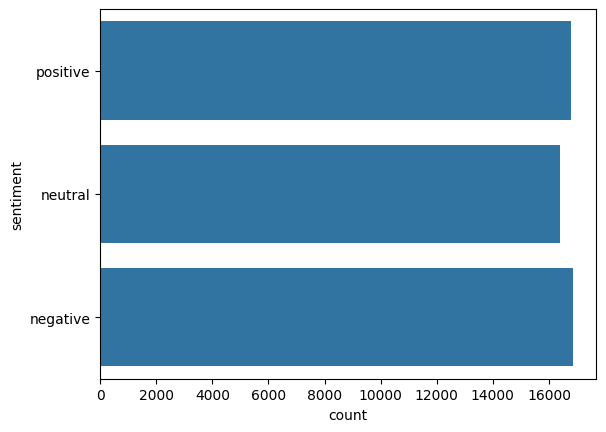

In [4]:
sns.countplot(df['sentiment'])
df['sentiment'].value_counts()

In [5]:
print(df.duplicated().sum())

49700


In [6]:
df.drop_duplicates(inplace=True)

sentiment
positive    100
neutral     100
negative    100
Name: count, dtype: int64

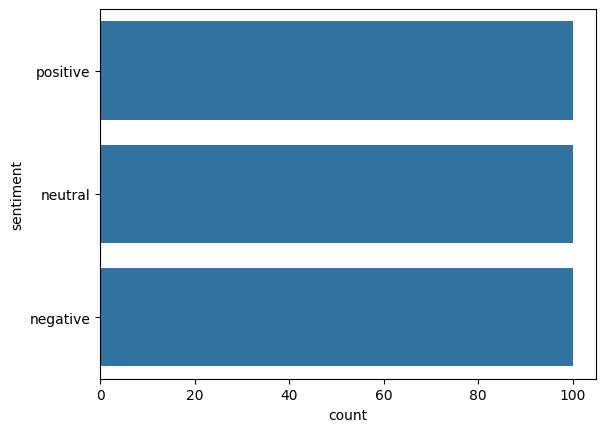

In [7]:
sns.countplot(df['sentiment'])
df['sentiment'].value_counts()

#### Observations
- There are 49700 duplicate reviews, leaving 300 unique reviews once duplicates are dropped
- There are 100 reviews of each sentiment category

### Collect and clean customer reviews from a given dataset (or scrape data if available)

#### Perform text cleaning (lowercasing, removing punctuation, stopword removal, lemmatization)
#### Tokenize 

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', "", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

### Feature Engineering

In [9]:
df['cleaned'] = df['review_text'].apply(clean_text)

In [10]:
df['sentiment'] = df['sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0})

In [11]:
df.head()

,review_text,sentiment,cleaned
0,"The entire process was easy, and the availabil...",2,entire process easy availability high quality
1,Standard rental process. The mobile app was ac...,1,standard rental process mobile app acceptable
2,One of the best bike rentals I’ve had. The mob...,2,one best bike rental ’ mobile app made even be...
3,One of the best bike rentals I’ve had. The cus...,2,one best bike rental ’ customer service made e...
4,Not worth the money. The seat comfort was a ma...,0,worth money seat comfort major letdown


In [12]:
df['cleaned'].head()

0        entire process easy availability high quality
1        standard rental process mobile app acceptable
2    one best bike rental ’ mobile app made even be...
3    one best bike rental ’ customer service made e...
4               worth money seat comfort major letdown
Name: cleaned, dtype: object

In [13]:
X = df['cleaned']
y = df['sentiment']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Vectorize the text

In [15]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


### Task 2: Sentiment analysis. Build a sentiment classification model (positive, neutral, negative)

#### Traditional models: 
##### Logistic Regression

In [16]:
log_model = LogisticRegression()
log_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [17]:
y_pred_log = log_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Confusion Matrix:
[[23  0  0]
 [ 0 17  0]
 [ 0  0 20]]


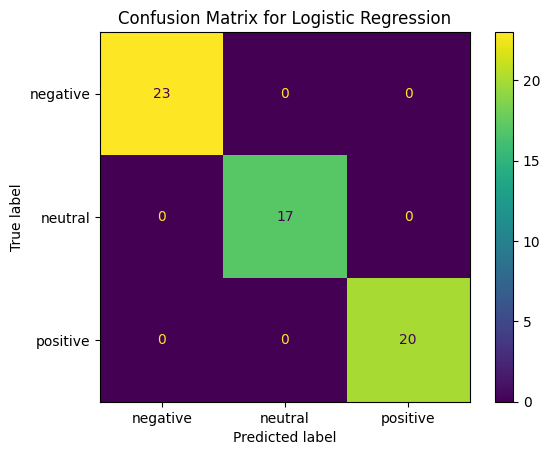

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred_log)
print("Confusion Matrix:")
print(conf_matrix)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['negative', 'neutral', 'positive'])
cm_display.plot()
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

##### Naïve Bayes

In [19]:
NB_model = MultinomialNB()
NB_model.fit(X_train_tfidf, y_train)


MultinomialNB()

In [20]:
y_pred_NB = NB_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Confusion Matrix:
[[23  0  0]
 [ 0 17  0]
 [ 0  0 20]]


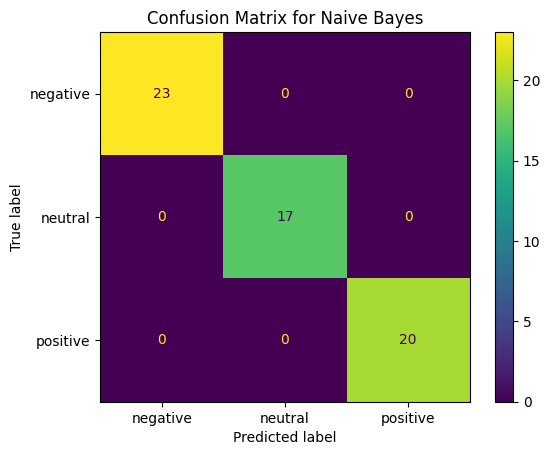

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred_NB)
print("Confusion Matrix:")
print(conf_matrix)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['negative', 'neutral', 'positive'])
cm_display.plot()
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

##### Observations
- Logistic Regression and Naive Bayes Models both had 100% in all metrics of classification report

#### Deep learning models: 
##### LSTM

In [22]:
max_words = 10000
max_len = 100

In [23]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [24]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [25]:
X_train_sequences = pad_sequences(sequences_train, maxlen=max_len, padding='post', truncating='post')
X_test_sequences = pad_sequences(sequences_test, maxlen=max_len, padding='post', truncating='post')

In [26]:
LSTM_RNN_model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128)),
    Dense(3, activation='softmax')
])

LSTM_RNN_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

LSTM_history = LSTM_RNN_model.fit(X_train_sequences, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10


/Users/cullen/Documents/Python-Projects/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.3424 - loss: 1.1012 - val_accuracy: 0.2292 - val_loss: 1.1032
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3809 - loss: 1.0781 - val_accuracy: 0.2292 - val_loss: 1.1087
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3613 - loss: 1.0635 - val_accuracy: 0.2292 - val_loss: 1.0826
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4056 - loss: 1.0271 - val_accuracy: 0.2500 - val_loss: 1.0450
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5794 - loss: 0.9868 - val_accuracy: 0.5208 - val_loss: 0.9883
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6068 - loss: 0.9065 - val_accuracy: 0.5417 - val_loss: 0.9331
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6960 - loss: 0.8049 - val_accuracy: 0.8542 - val_loss: 0.8060
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9095 - loss: 0.6746 - val_accuracy: 0.8333 - val_loss: 0.7112
Epo

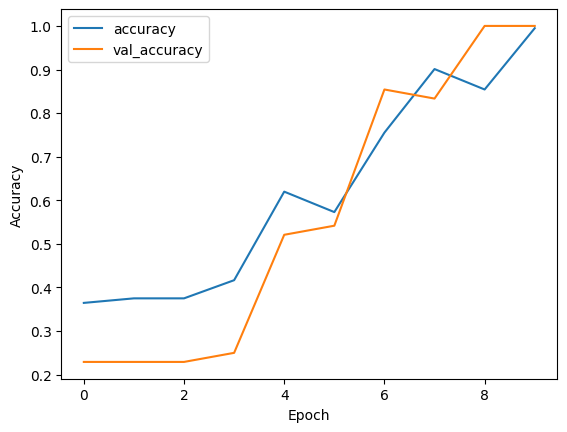

In [27]:
plt.plot(LSTM_history.history['accuracy'], label='accuracy')
plt.plot(LSTM_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### Evaluate models using accuracy, F1-score, and confusion matrix

In [28]:
y_pred_LSTM = LSTM_RNN_model.predict(X_test_sequences)
y_pred_LSTM_classes = np.argmax(y_pred_LSTM, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


In [29]:
y_pred_LSTM_classes

array([2, 1, 1, 1, 2, 0, 2, 1, 0, 2, 0, 2, 2, 0, 0, 1, 2, 2, 2, 2, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 2, 2, 2, 0, 2, 0, 1, 1, 2, 2, 1, 1, 2, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1])

In [30]:
print(classification_report(y_test, y_pred_LSTM_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



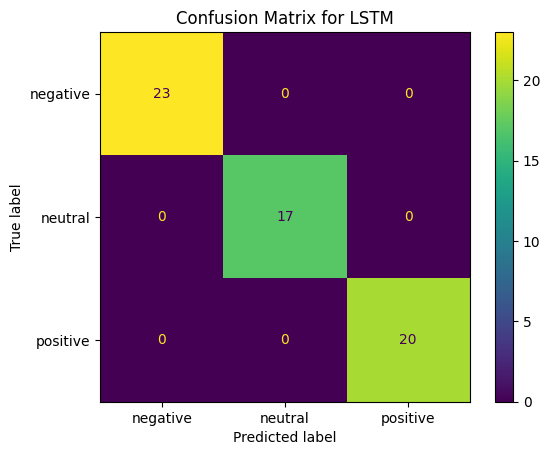

In [31]:
conf_matrix = confusion_matrix(y_test, y_pred_LSTM_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['negative', 'neutral', 'positive'])
cm_display.plot()
plt.title('Confusion Matrix for LSTM')
plt.show()

##### Observations
- LSTM neural network scored 100% on all metrics of classification report as well
- After 5 epochs, the validation accuracy is higher than the training accuracy

##### Transformers (BERT)

In [32]:
Bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
Bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3) # 3 labels: negative, neutral, positive

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
train_encodings = Bert_tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors='tf')
test_encodings = Bert_tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors='tf'),

In [34]:
train_encodings['input_ids'].shape, train_encodings['attention_mask'].shape

(TensorShape([240, 12]), TensorShape([240, 12]))

In [35]:
test_encodings[0]['input_ids'].shape, test_encodings[0]['attention_mask'].shape

(TensorShape([60, 12]), TensorShape([60, 12]))

In [36]:
Bert_model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

Bert_history = Bert_model.fit(train_encodings['input_ids'], y_train, epochs=10, batch_size=64,validation_split=0.2)

Epoch 1/10
3/3 [==============================] - 12s 3s/step - loss: 1.2654 - accuracy: 0.3177 - val_loss: 1.1038 - val_accuracy: 0.4167
Epoch 2/10
3/3 [==============================] - 5s 2s/step - loss: 1.1889 - accuracy: 0.3594 - val_loss: 1.1158 - val_accuracy: 0.2292
Epoch 3/10
3/3 [==============================] - 5s 2s/step - loss: 1.1587 - accuracy: 0.2969 - val_loss: 1.1470 - val_accuracy: 0.2292
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 1.1546 - accuracy: 0.3438 - val_loss: 1.1476 - val_accuracy: 0.2292
Epoch 5/10
3/3 [==============================] - 5s 2s/step - loss: 1.1038 - accuracy: 0.3594 - val_loss: 1.1024 - val_accuracy: 0.4167
Epoch 6/10
3/3 [==============================] - 5s 2s/step - loss: 1.1054 - accuracy: 0.3698 - val_loss: 1.1231 - val_accuracy: 0.2292
Epoch 7/10
3/3 [==============================] - 5s 2s/step - loss: 1.1172 - accuracy: 0.3646 - val_loss: 1.1623 - val_accuracy: 0.2292
Epoch 8/10
3/3 [========================

In [37]:
y_pred_bert = np.argmax(Bert_model.predict(test_encodings[0]['input_ids'])[0], axis=1)

2/2 [==============================] - 2s 254ms/step


In [38]:
print(classification_report(y_test, y_pred_bert))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.28      1.00      0.44        17
           2       0.00      0.00      0.00        20

    accuracy                           0.28        60
   macro avg       0.09      0.33      0.15        60
weighted avg       0.08      0.28      0.13        60



/Users/cullen/Documents/Python-Projects/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cullen/Documents/Python-Projects/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cullen/Documents/Python-Projects/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

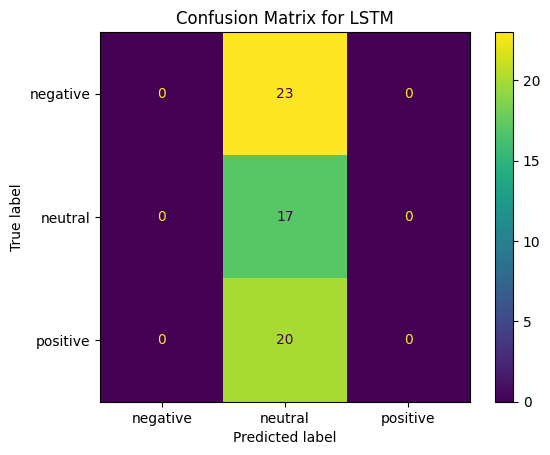

In [39]:
conf_matrix = confusion_matrix(y_test, y_pred_bert)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['negative', 'neutral', 'positive'])
cm_display.plot()
plt.title('Confusion Matrix for LSTM')
plt.show()

##### Observations:
- BERT models seem to perform significantly worse than the simpler models
- Transformers models may not do well with smaller datasets, which is why the transitional models may have performed better
- Data may also have too simple language in the reviews, resulting in overkill by the contextual understanding of a transformer, which also might be picking up on noise

# Conclusion 
- Simpler models, such as logistic, naive bayes, and LSTM, appear to perform better than the BERT transformer model for this dataset
- BERT Transformer may perform better on a more complex or larger dataset to capture relationships within the data that the simplier models may not have the capacity for